In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/archive/Info.txt
/content/drive/MyDrive/archive/all-mias.tar.gz
/content/drive/MyDrive/archive/all_mias_scans.h5
/content/drive/MyDrive/archive/slicedImgNEW1.h5/slicedImgNEW1.h5
/content/drive/MyDrive/archive/slicedImg1.h5/slicedImg1.h5
/content/drive/MyDrive/archive/csvfiles/INBreast_config.csv
/content/drive/MyDrive/archive/INbreast Release 1.0/INbreast.csv
/content/drive/MyDrive/archive/INbreast Release 1.0/INbreast.xls
/content/drive/MyDrive/archive/INbreast Release 1.0/README.txt
/content/drive/MyDrive/archive/INbreast Release 1.0/benign/1000_C_0334_1.LEFT_CC.LJPEG.1_highpass.png
/content/drive/MyDrive/archive/INbreast Release 1.0/AllDICOMs/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm
/content/drive/MyDrive/archive/INbreast Release 1.0/AllDICOMs/20586934_6c613a14b80a8591_MG_L_CC_ANON.dcm
/content/drive/MyDrive/archive/INbreast Release 1.0/AllDICOMs/20586960_6c613a14b80a8591_MG_R_ML_ANON.dcm
/content/drive/MyDrive/archive/INbreast Release 1.0/AllDICOMs/20586986

**Importing all the necessary packages.**

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from tqdm.notebook import tqdm
import cv2
from sklearn.model_selection import train_test_split
import random

In [4]:
imgs_path = '/content/drive/MyDrive/archive/all-mias/' #assigning the image path value to imgs_path

**Reading the dataframe**

In [5]:
info=pd.read_csv("/content/drive/MyDrive/archive/Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)

In [6]:
info

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [7]:
ids = {}
for i in range(len(info)):
    ids[i] = info.REFNUM[i]

In [8]:
# Turning our outputs Normal-Abnormal to 0-1
label = []
for i in range(len(info)):
    if info.CLASS[i] != 'NORM':
        label.append(1)
    else:
        label.append(0)
label = np.array(label)
print(f"Total Images: {len(label)}\nNormales: {len(label)-np.sum(label)}\n abnormales: {np.sum(label)}")

Total Images: 330
Normales: 207
No normales: 123


In [9]:
# define the every images filepaths in to list
img_name = []

for i in range(len(label)):
        img_name.append(imgs_path + info.REFNUM[i]+ '.pgm')

In [10]:
count = 0
remove = True
temp_label = []
temp_img_name = []

for i, lbl in enumerate(label.tolist()):
    if lbl == 0 and remove == True:
        count = count + 1
        if count >= 84:
            remove = False
    else:
        temp_label.append(lbl)
        temp_img_name.append(img_name[i])
label = np.array(temp_label)
img_name = temp_img_name

In [11]:
img_name = np.array(img_name)
img_name.shape

(246,)

In [12]:
print(img_name)
print(f'image address amount {img_name.shape}')

['/content/drive/MyDrive/archive/all-mias/mdb001.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb002.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb005.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb005.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb010.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb012.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb013.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb015.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb017.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb019.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb021.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb023.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb025.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb028.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb030.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb032.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb058.pgm'
 '/content/drive/MyDrive/archive/all-mias/mdb059.pgm'
 '/content/drive/MyDrive/arc

In [13]:
img_path = []
last_label = []
IMG_SIZE = 128

for i in range(len(img_name)):

    img = cv2.imread(img_name[i], 0)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    rows, cols= img.shape
    for angle in range(180):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle*2, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
            img_path.append(img_rotated)
            if label[i] == 1:
                last_label.append(1)
            else:
                last_label.append(0)

In [14]:
img_path = np.array(img_path)
last_label = np.array(last_label)
img_path.shape

(44280, 128, 128)

In [15]:
img_path = img_path.reshape((-1,IMG_SIZE,IMG_SIZE,1))
img_path.shape

(44280, 128, 128, 1)

In [16]:
last_label.shape

(44280,)

In [17]:
# split train and test set
x_train, x_test, y_train, y_test = train_test_split(img_path, last_label, test_size = 0.3, random_state = 42)

In [18]:
len(x_train),len(x_test),len(y_train),len(y_test)

(30996, 13284, 30996, 13284)

CNN Model

In [19]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.activations import *
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time

In [20]:
reg = tf.keras.regularizers.L2(l2=1e-5)
ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)


model = Sequential()
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer = ini,
                 input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Conv2D(64,
                 kernel_size=(3,3),
                 kernel_initializer = ini,
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64,
                 kernel_size=(3,3),
                 kernel_initializer = ini,
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Dense(64,
                kernel_initializer = ini,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3)

model.compile(optimizer=optimizer,
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0

In [22]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5 ,restore_best_weights=True, verbose=1)

check_point_filepath = './'

model_check_point = ModelCheckpoint(filepath =check_point_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                    save_weights_only=False, mode='auto', save_freq='epoch')

In [23]:
train = True
if train:
    epochs=100
    history = model.fit(x_train,
                 y_train,
                 validation_split=0.2,
                 epochs=epochs,
                 batch_size=128,
                 callbacks=[early_stop, model_check_point])
else:
    model = tf.keras.models.load_model('/content/drive/MyDrive/archive/')

Epoch 1/100
194/194 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5059
Epoch 1: val_loss improved from inf to 0.69195, saving model to ./


194/194 [==============================] - 54s 192ms/step - loss: 0.6936 - accuracy: 0.5059 - val_loss: 0.6920 - val_accuracy: 0.5352
Epoch 2/100
194/194 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.5485
Epoch 2: val_loss improved from 0.69195 to 0.66565, saving model to ./


194/194 [==============================] - 35s 183ms/step - loss: 0.6835 - accuracy: 0.5485 - val_loss: 0.6656 - val_accuracy: 0.5797
Epoch 3/100
194/194 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.5963
Epoch 3: val_loss improved from 0.66565 to 0.64566, saving model to ./


194/194 [==============================] - 34s 177ms/step - loss: 0.6561 - accuracy: 0.5963 - val_loss: 0.6457 - val_accuracy: 0.6032
Epoch 4/100
194/194 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.6240
Epoch 4: val_loss improved from 0.64566 to 0.62595, saving model to ./


194/194 [==============================] - 35s 182ms/step - loss: 0.6307 - accuracy: 0.6240 - val_loss: 0.6259 - val_accuracy: 0.6290
Epoch 5/100
194/194 [==============================] - ETA: 0s - loss: 0.6069 - accuracy: 0.6472
Epoch 5: val_loss improved from 0.62595 to 0.60950, saving model to ./


194/194 [==============================] - 35s 181ms/step - loss: 0.6069 - accuracy: 0.6472 - val_loss: 0.6095 - val_accuracy: 0.6516
Epoch 6/100
194/194 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.6744
Epoch 6: val_loss improved from 0.60950 to 0.60269, saving model to ./


194/194 [==============================] - 35s 179ms/step - loss: 0.5799 - accuracy: 0.6744 - val_loss: 0.6027 - val_accuracy: 0.6661
Epoch 7/100
194/194 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.6969
Epoch 7: val_loss improved from 0.60269 to 0.57048, saving model to ./


194/194 [==============================] - 34s 174ms/step - loss: 0.5503 - accuracy: 0.6969 - val_loss: 0.5705 - val_accuracy: 0.6827
Epoch 8/100
194/194 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.7182
Epoch 8: val_loss improved from 0.57048 to 0.53931, saving model to ./


194/194 [==============================] - 34s 177ms/step - loss: 0.5230 - accuracy: 0.7182 - val_loss: 0.5393 - val_accuracy: 0.7068
Epoch 9/100
194/194 [==============================] - ETA: 0s - loss: 0.4920 - accuracy: 0.7397
Epoch 9: val_loss improved from 0.53931 to 0.53020, saving model to ./


194/194 [==============================] - 37s 189ms/step - loss: 0.4920 - accuracy: 0.7397 - val_loss: 0.5302 - val_accuracy: 0.7273
Epoch 10/100
194/194 [==============================] - ETA: 0s - loss: 0.4641 - accuracy: 0.7641
Epoch 10: val_loss improved from 0.53020 to 0.51004, saving model to ./


194/194 [==============================] - 36s 186ms/step - loss: 0.4641 - accuracy: 0.7641 - val_loss: 0.5100 - val_accuracy: 0.7406
Epoch 11/100
194/194 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.7736
Epoch 11: val_loss improved from 0.51004 to 0.47412, saving model to ./


194/194 [==============================] - 34s 176ms/step - loss: 0.4419 - accuracy: 0.7736 - val_loss: 0.4741 - val_accuracy: 0.7569
Epoch 12/100
194/194 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.7917
Epoch 12: val_loss improved from 0.47412 to 0.46789, saving model to ./


194/194 [==============================] - 34s 178ms/step - loss: 0.4146 - accuracy: 0.7917 - val_loss: 0.4679 - val_accuracy: 0.7729
Epoch 13/100
194/194 [==============================] - ETA: 0s - loss: 0.3881 - accuracy: 0.8105
Epoch 13: val_loss improved from 0.46789 to 0.44196, saving model to ./


194/194 [==============================] - 35s 180ms/step - loss: 0.3881 - accuracy: 0.8105 - val_loss: 0.4420 - val_accuracy: 0.7847
Epoch 14/100
194/194 [==============================] - ETA: 0s - loss: 0.3619 - accuracy: 0.8276
Epoch 14: val_loss improved from 0.44196 to 0.42639, saving model to ./


194/194 [==============================] - 36s 184ms/step - loss: 0.3619 - accuracy: 0.8276 - val_loss: 0.4264 - val_accuracy: 0.8015
Epoch 15/100
194/194 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8381
Epoch 15: val_loss improved from 0.42639 to 0.40515, saving model to ./


194/194 [==============================] - 35s 180ms/step - loss: 0.3433 - accuracy: 0.8381 - val_loss: 0.4051 - val_accuracy: 0.8085
Epoch 16/100
194/194 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.8498
Epoch 16: val_loss improved from 0.40515 to 0.39328, saving model to ./


194/194 [==============================] - 35s 182ms/step - loss: 0.3205 - accuracy: 0.8498 - val_loss: 0.3933 - val_accuracy: 0.8250
Epoch 17/100
194/194 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8616
Epoch 17: val_loss improved from 0.39328 to 0.37766, saving model to ./


194/194 [==============================] - 35s 180ms/step - loss: 0.3015 - accuracy: 0.8616 - val_loss: 0.3777 - val_accuracy: 0.8302
Epoch 18/100
194/194 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.8716
Epoch 18: val_loss improved from 0.37766 to 0.37177, saving model to ./


194/194 [==============================] - 34s 177ms/step - loss: 0.2823 - accuracy: 0.8716 - val_loss: 0.3718 - val_accuracy: 0.8379
Epoch 19/100
194/194 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8783
Epoch 19: val_loss improved from 0.37177 to 0.34982, saving model to ./


194/194 [==============================] - 34s 176ms/step - loss: 0.2698 - accuracy: 0.8783 - val_loss: 0.3498 - val_accuracy: 0.8448
Epoch 20/100
194/194 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.8882
Epoch 20: val_loss improved from 0.34982 to 0.34571, saving model to ./


194/194 [==============================] - 34s 175ms/step - loss: 0.2530 - accuracy: 0.8882 - val_loss: 0.3457 - val_accuracy: 0.8515
Epoch 21/100
194/194 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.8930
Epoch 21: val_loss improved from 0.34571 to 0.33676, saving model to ./


194/194 [==============================] - 35s 181ms/step - loss: 0.2416 - accuracy: 0.8930 - val_loss: 0.3368 - val_accuracy: 0.8524
Epoch 22/100
194/194 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.9014
Epoch 22: val_loss improved from 0.33676 to 0.33128, saving model to ./


194/194 [==============================] - 35s 180ms/step - loss: 0.2290 - accuracy: 0.9014 - val_loss: 0.3313 - val_accuracy: 0.8621
Epoch 23/100
194/194 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9035
Epoch 23: val_loss did not improve from 0.33128
194/194 [==============================] - 33s 169ms/step - loss: 0.2209 - accuracy: 0.9035 - val_loss: 0.3357 - val_accuracy: 0.8598
Epoch 24/100
194/194 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9108
Epoch 24: val_loss improved from 0.33128 to 0.33086, saving model to ./


194/194 [==============================] - 34s 176ms/step - loss: 0.2079 - accuracy: 0.9108 - val_loss: 0.3309 - val_accuracy: 0.8671
Epoch 25/100
194/194 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9112
Epoch 25: val_loss improved from 0.33086 to 0.30107, saving model to ./


194/194 [==============================] - 34s 177ms/step - loss: 0.2063 - accuracy: 0.9112 - val_loss: 0.3011 - val_accuracy: 0.8718
Epoch 26/100
194/194 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9175
Epoch 26: val_loss did not improve from 0.30107
194/194 [==============================] - 33s 168ms/step - loss: 0.1920 - accuracy: 0.9175 - val_loss: 0.3285 - val_accuracy: 0.8752
Epoch 27/100
194/194 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.9230
Epoch 27: val_loss improved from 0.30107 to 0.29456, saving model to ./


194/194 [==============================] - 34s 175ms/step - loss: 0.1824 - accuracy: 0.9230 - val_loss: 0.2946 - val_accuracy: 0.8898
Epoch 28/100
194/194 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9250
Epoch 28: val_loss did not improve from 0.29456
194/194 [==============================] - 34s 174ms/step - loss: 0.1775 - accuracy: 0.9250 - val_loss: 0.3058 - val_accuracy: 0.8798
Epoch 29/100
194/194 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9304
Epoch 29: val_loss improved from 0.29456 to 0.26929, saving model to ./


194/194 [==============================] - 34s 174ms/step - loss: 0.1696 - accuracy: 0.9304 - val_loss: 0.2693 - val_accuracy: 0.8921
Epoch 30/100
194/194 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9339
Epoch 30: val_loss improved from 0.26929 to 0.26824, saving model to ./


194/194 [==============================] - 35s 180ms/step - loss: 0.1573 - accuracy: 0.9339 - val_loss: 0.2682 - val_accuracy: 0.8990
Epoch 31/100
194/194 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9365
Epoch 31: val_loss did not improve from 0.26824
194/194 [==============================] - 34s 173ms/step - loss: 0.1556 - accuracy: 0.9365 - val_loss: 0.2875 - val_accuracy: 0.8931
Epoch 32/100
194/194 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9395
Epoch 32: val_loss improved from 0.26824 to 0.25355, saving model to ./


194/194 [==============================] - 36s 184ms/step - loss: 0.1518 - accuracy: 0.9395 - val_loss: 0.2535 - val_accuracy: 0.9037
Epoch 33/100
194/194 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9427
Epoch 33: val_loss did not improve from 0.25355
194/194 [==============================] - 33s 168ms/step - loss: 0.1455 - accuracy: 0.9427 - val_loss: 0.2571 - val_accuracy: 0.9024
Epoch 34/100
194/194 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9437
Epoch 34: val_loss did not improve from 0.25355
194/194 [==============================] - 34s 174ms/step - loss: 0.1413 - accuracy: 0.9437 - val_loss: 0.2782 - val_accuracy: 0.9056
Epoch 35/100
194/194 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9463
Epoch 35: val_loss did not improve from 0.25355
194/194 [==============================] - 33s 168ms/step - loss: 0.1424 - accuracy: 0.9463 - val_loss: 0.2872 - val_accuracy: 0.9045
Epoch 36/100
194/194 [====

194/194 [==============================] - 34s 177ms/step - loss: 0.1242 - accuracy: 0.9515 - val_loss: 0.2382 - val_accuracy: 0.9140
Epoch 38/100
194/194 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9506
Epoch 38: val_loss did not improve from 0.23824
194/194 [==============================] - 34s 173ms/step - loss: 0.1248 - accuracy: 0.9506 - val_loss: 0.2547 - val_accuracy: 0.9108
Epoch 39/100
194/194 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9522
Epoch 39: val_loss improved from 0.23824 to 0.22787, saving model to ./


194/194 [==============================] - 35s 182ms/step - loss: 0.1263 - accuracy: 0.9522 - val_loss: 0.2279 - val_accuracy: 0.9176
Epoch 40/100
194/194 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9537
Epoch 40: val_loss did not improve from 0.22787
194/194 [==============================] - 33s 169ms/step - loss: 0.1178 - accuracy: 0.9537 - val_loss: 0.2528 - val_accuracy: 0.9127
Epoch 41/100
194/194 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9556
Epoch 41: val_loss did not improve from 0.22787
194/194 [==============================] - 34s 173ms/step - loss: 0.1179 - accuracy: 0.9556 - val_loss: 0.2531 - val_accuracy: 0.9185
Epoch 42/100
194/194 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9551
Epoch 42: val_loss did not improve from 0.22787
194/194 [==============================] - 34s 174ms/step - loss: 0.1139 - accuracy: 0.9551 - val_loss: 0.2345 - val_accuracy: 0.9194
Epoch 43/100
194/194 [====

194/194 [==============================] - 34s 174ms/step - loss: 0.1067 - accuracy: 0.9591 - val_loss: 0.2205 - val_accuracy: 0.9250
Epoch 44/100
194/194 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9595
Epoch 44: val_loss improved from 0.22048 to 0.21042, saving model to ./


194/194 [==============================] - 34s 177ms/step - loss: 0.1081 - accuracy: 0.9595 - val_loss: 0.2104 - val_accuracy: 0.9256
Epoch 45/100
194/194 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9583
Epoch 45: val_loss improved from 0.21042 to 0.20668, saving model to ./


194/194 [==============================] - 35s 181ms/step - loss: 0.1127 - accuracy: 0.9583 - val_loss: 0.2067 - val_accuracy: 0.9258
Epoch 46/100
194/194 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9576
Epoch 46: val_loss did not improve from 0.20668
194/194 [==============================] - 34s 173ms/step - loss: 0.1133 - accuracy: 0.9576 - val_loss: 0.2313 - val_accuracy: 0.9194
Epoch 47/100
194/194 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9612
Epoch 47: val_loss did not improve from 0.20668
194/194 [==============================] - 34s 174ms/step - loss: 0.1055 - accuracy: 0.9612 - val_loss: 0.2245 - val_accuracy: 0.9269
Epoch 48/100
194/194 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9598
Epoch 48: val_loss did not improve from 0.20668
194/194 [==============================] - 34s 174ms/step - loss: 0.1024 - accuracy: 0.9598 - val_loss: 0.2468 - val_accuracy: 0.9235
Epoch 49/100
194/194 [====

1/1 [==============================] - 0s 199ms/step
The results was: True       And the probability being: 0.995002806186676
Real value was: True
Test id: 1132


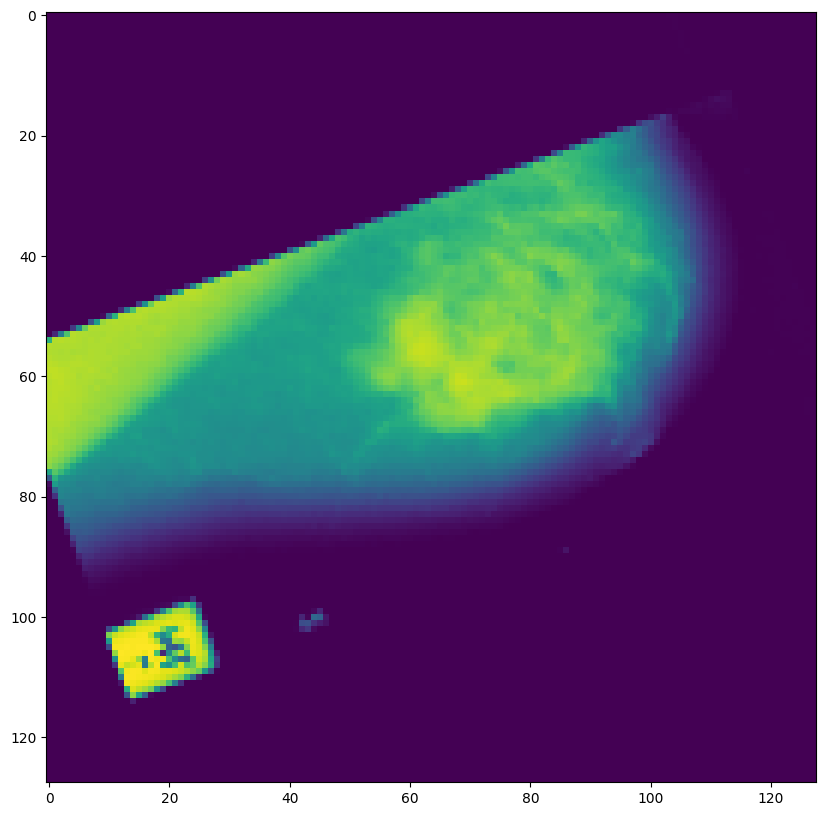

In [24]:
from random import randint
test_num = randint(0,len(x_test))
#test_num = 6948
result = model.predict(np.array([x_test[test_num]]))

plt.figure(figsize= (10,10))
plt.imshow(x_test[test_num])

print(f"The results was: {result[0][0]>= 0.5}       And the probability being: {result[0][0]}\nReal value was: {y_test[test_num]>=0.5}")
print(f"Test id: {test_num}")

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

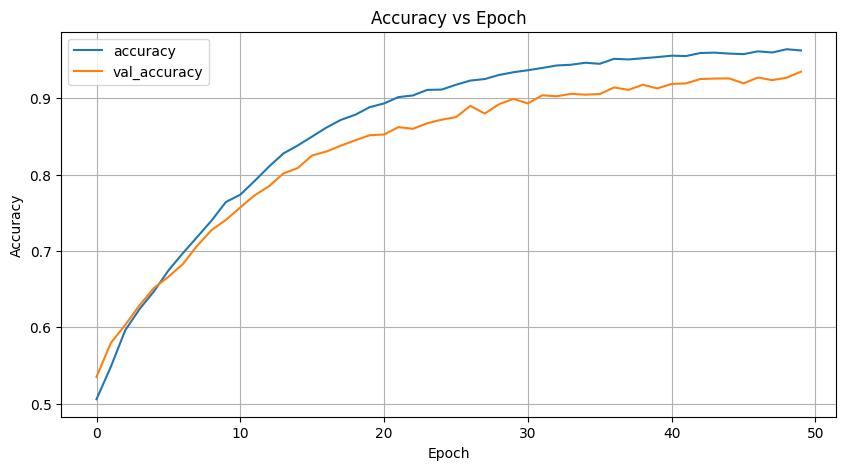

In [26]:
plt.figure(figsize=(10,5))
plt.plot(range(len(history.history['accuracy'])),history.history['accuracy'], label= "accuracy")
plt.plot(range(0,len(history.history['val_accuracy'])),history.history['val_accuracy'], label= "val_accuracy")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.show()

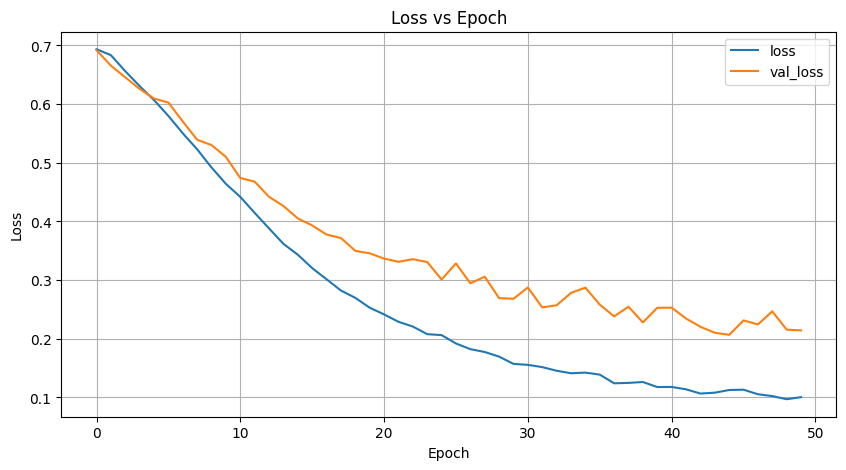

In [27]:
plt.figure(figsize=(10,5))
plt.plot(range(0,len(history.history['loss'])),history.history['loss'], label= "loss")
plt.plot(range(0,len(history.history['val_loss'])),history.history['val_loss'], label= "val_loss")
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

In [28]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

416/416 - 5s - loss: 0.2016 - accuracy: 0.9298 - 5s/epoch - 13ms/step

Test accuracy: 0.9298403859138489


In [29]:
len(x_test)

13284

In [30]:
y_pred=model.predict(x_test)

416/416 [==============================] - 5s 11ms/step


In [31]:
y_pred.shape

(13284, 1)

In [32]:
len(last_label)

44280

In [33]:
y_test

array([1, 1, 1, ..., 0, 0, 0])

In [34]:
y_pred

array([[8.4684861e-01],
       [9.4752997e-01],
       [9.9999475e-01],
       ...,
       [3.5912273e-11],
       [1.0633411e-01],
       [2.0198175e-03]], dtype=float32)

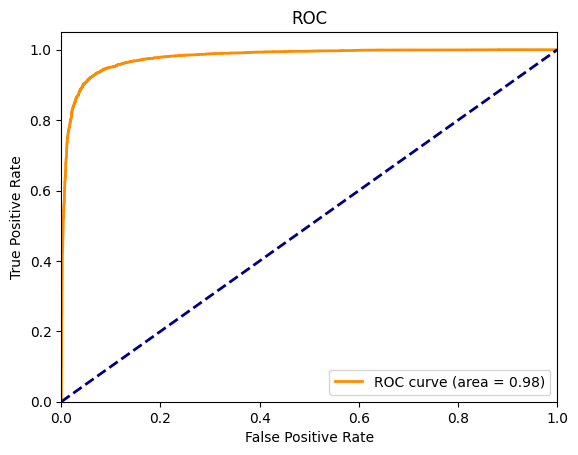

In [35]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#roc plot for specific class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
pred_prob = model.predict(x_test)
#auc scores
auc_score = roc_auc_score(y_test, pred_prob)
print(auc_score)

416/416 [==============================] - 5s 12ms/step
0.9787139228560091


In [37]:
save_model = True
if save_model:
    save_model_path = "/content/drive/MyDrive/archive/Prashant/"
    model.save("pretrained_model.h5")